# FiBiNET

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, fibinet, CyclicLR, MaxLrFinder, linear_regression
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:09, 62340.73it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:06, 62419.42it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:11, 51103.30it/s]
400000it [00:07, 53361.13it/s]


经过之前的实验，发现直接训练效果并不好，所以我们将先分别预训练linear和em的权重，最后在进行融合。

# PRETRAIN

so, 我们用十分之一的数据训练一个epoch, 作为lr部分的权重.

In [38]:
class PreTrain(object):
    def __init__(self, model):
        self.model = model
    
    def get_trainable_w(self, layers):
        trainable_w = []
        for layer in layers:
            for w in self.model.get_layer(layer).weights:
                trainable_w.append(w.name)
        return trainable_w
    
    def set_trainable(self, layers):
        for l in self.model.layers:
            if l.name in layers:
                l.trainable = True
            else:
                l.trainable = False
    
    def show_w(self, trainable_w):
        # loc
        len_p = len(trainable_w)
        loc1 = int(np.ceil(np.sqrt(len_p)))
        loc0 = int(np.ceil(len_p / loc1))

        plt.figure(figsize=[loc1 * 7, loc0 * 7])
        for idx, w in enumerate(self.model.weights):
            if w.name in trainable_w:
                plt.subplot(loc0, loc1, idx + 1)
                plt.hist(w.numpy())
                plt.xlabel(w.name)
                
    def fit(self, idx, val, y, train_size=0.1, epoch=1, batch_size=1000, base_lr=3, max_lr=3):
        # callbacks
        clr = CyclicLR(base_lr=0.1**(base_lr),
               max_lr = 0.1**(max_lr), 
               step_size= int(4.0*(train_df.shape[0] * train_size / batch_size)),
               mode='triangular2',
               gamma=1.0)
        
        es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=5, mode='max', restore_best_weights=True)
        # fit
        ss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=23333)
        for train_idx, test_idx in ss.split(X=idx, y=y_train):
            # train idx
            x_train_idx = idx[train_idx]
            x_train_val = val[train_idx]
            y_train_sp = y_train[train_idx]
            # test idx
            x_test_idx = idx[test_idx]
            x_test_val = val[test_idx]
            y_test_sp = y_train[test_idx]
            # fit
            self.model.fit(x=[x_train_idx, x_train_val],
                           y=y_train_sp,
                           epochs=epoch,
                           batch_size=batch_size,
                           verbose=1,
                           callbacks=[es, clr],
                           validation_data=([x_test_idx, x_test_val], y_test_sp))
            
    def Layers(self, layers='all'):
        layers = [l.name for l in self.model.layers] if layers == 'all' else layers
        self.set_trainable(layers)
        w_lst = self.get_trainable_w(layers)
        self.show_w(w_lst)
        
        
        
            

In [39]:
tf.keras.backend.clear_session()

model = fibinet(vocabulary_size=ecd.get_vocabulary(),
                feature_number=len(feature_col),
                activation='sigmoid',
                loss='binary_crossentropy', 
                metrics=['AUC'],
                optimizer='Adam',
                bi_type='all',
                use_deep=False)

# Linear

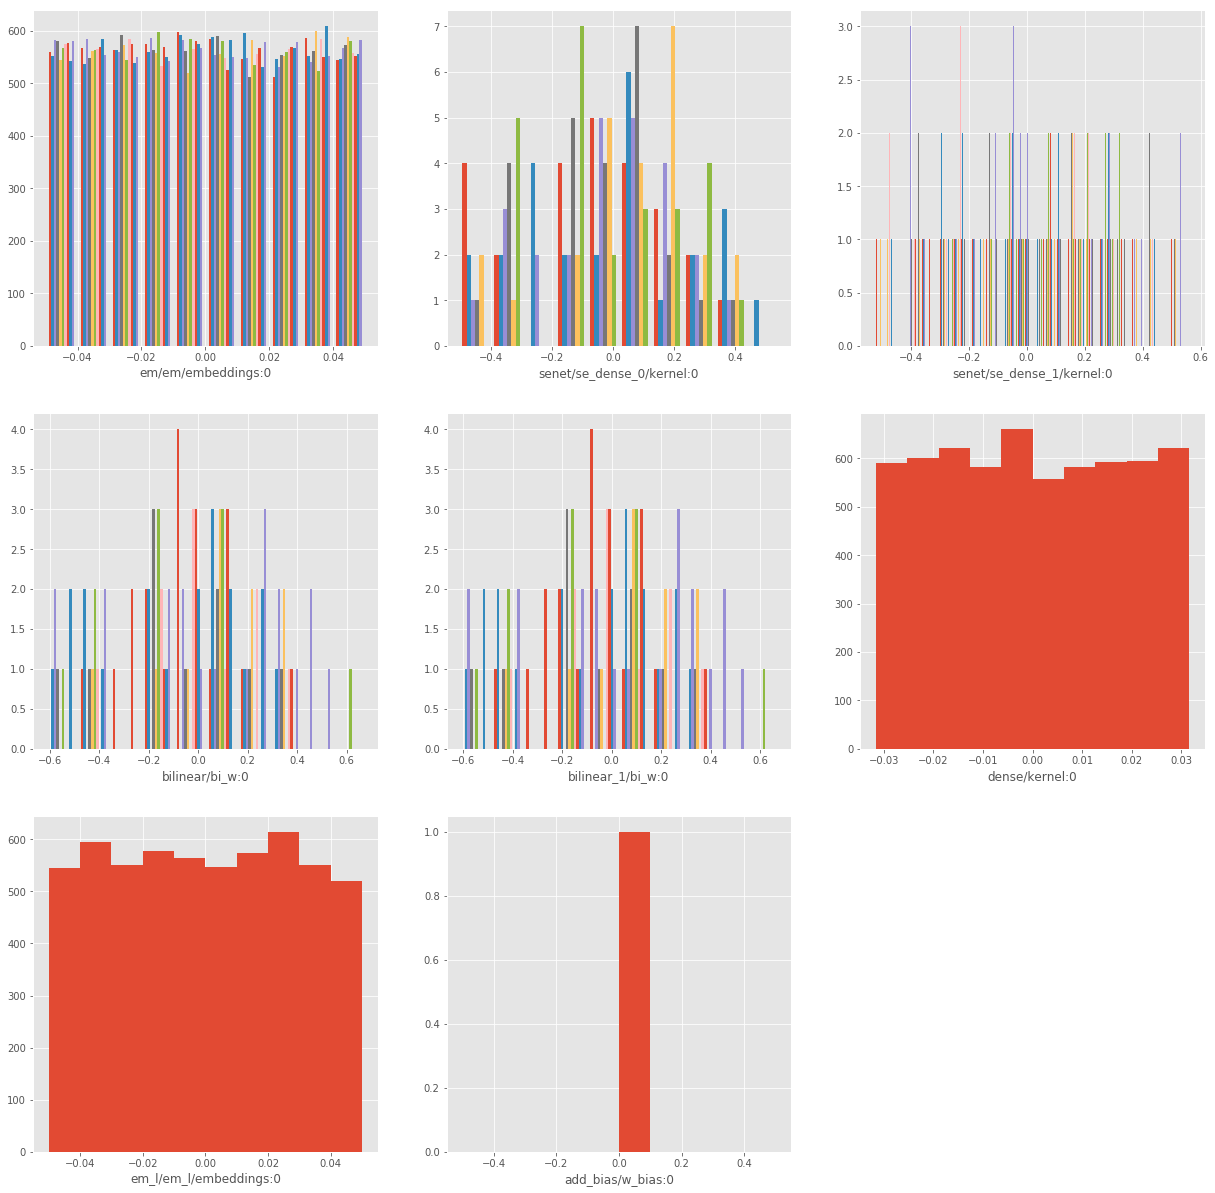

In [40]:
pt = PreTrain(model)
pt.Layers('all')

In [44]:
pt.fit(idx, val, y_train, train_size=0.01, epoch=1, batch_size=1000, base_lr=4, max_lr=4)

Train on 6000 samples, validate on 60000 samples
6000/6000 [==============================] - 1s 146us/sample - loss: 0.6228 - AUC: 0.5423 - val_loss: 0.6227 - val_AUC: 0.5103


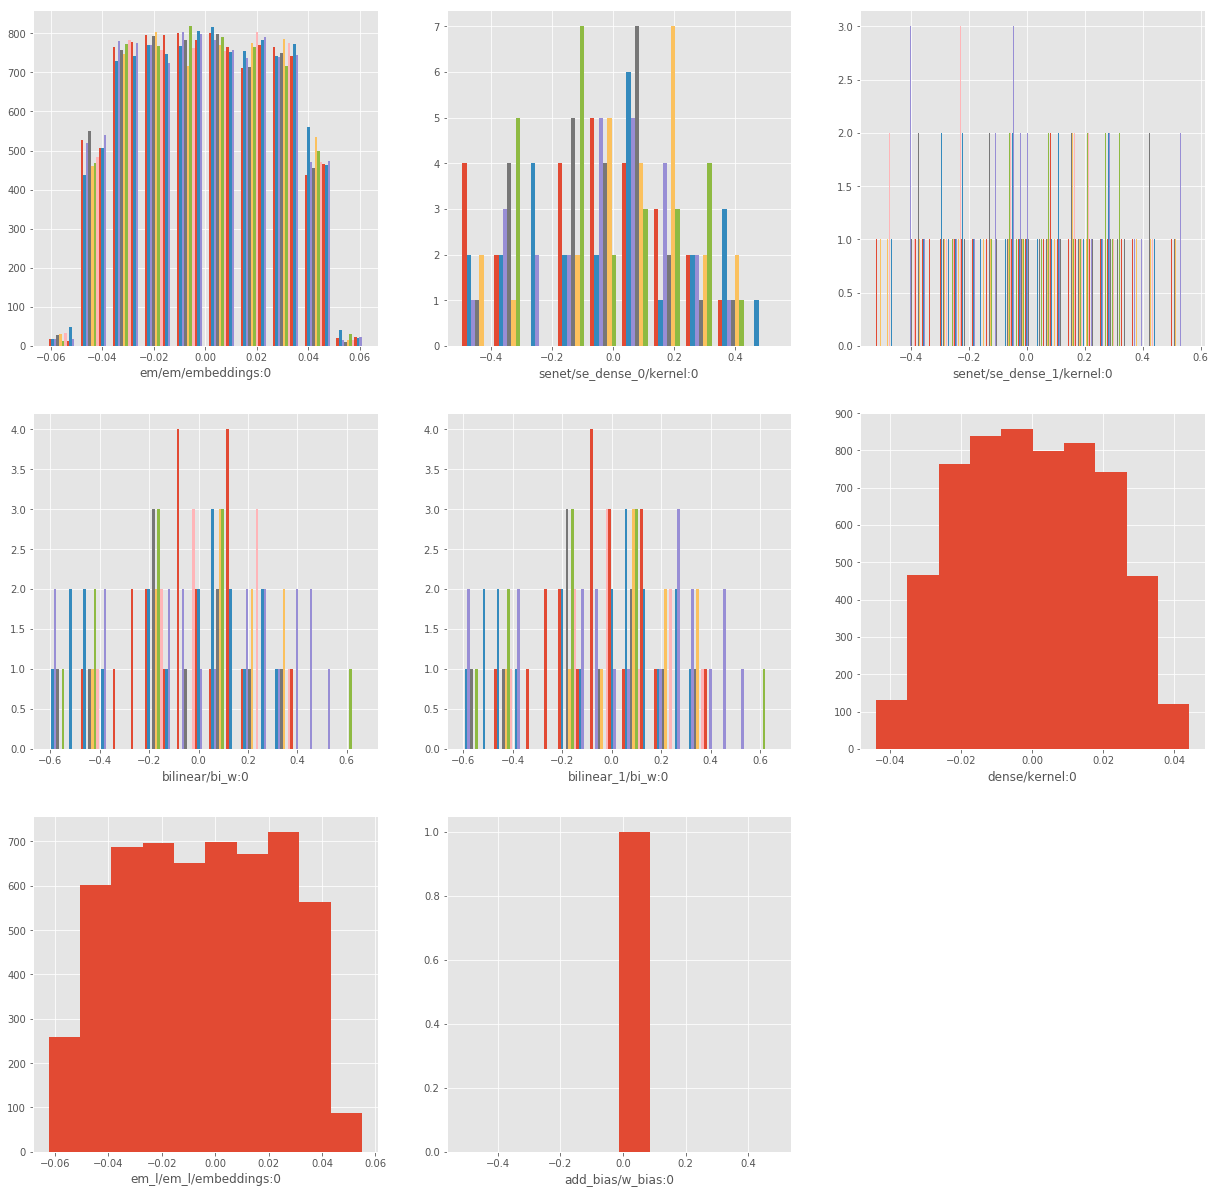

In [45]:
pt.Layers()

# fit one

In [46]:
%%time

batch_size = 1000
epochs = 100
nflod = 5

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3), 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

CPU times: user 56 µs, sys: 2 µs, total: 58 µs
Wall time: 62.9 µs


In [47]:
%%time


cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train,
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 68s 142us/sample - loss: 0.4966 - AUC: 0.5763 - val_loss: 0.4302 - val_AUC: 0.7614
Epoch 2/100
479999/479999 [==============================] - 16s 34us/sample - loss: 0.4033 - AUC: 0.7802 - val_loss: 0.3976 - val_AUC: 0.7870
Epoch 3/100
479999/479999 [==============================] - 16s 34us/sample - loss: 0.3932 - AUC: 0.7939 - val_loss: 0.3981 - val_AUC: 0.7869
Epoch 4/100
479999/479999 [==============================] - 16s 34us/sample - loss: 0.3924 - AUC: 0.7951 - val_loss: 0.3985 - val_AUC: 0.7865
Epoch 5/100
479999/479999 [==============================] - 16s 34us/sample - loss: 0.3916 - AUC: 0.7964 - val_loss: 0.3987 - val_AUC: 0.7868
folds 0 is done, score is 0.7870933756114791
Train on 479999 samples, validate on 120001 samples
Epoch 1/100
479999/479999 [==============================] - 59s 122us/sample - loss: 0.4436 - AUC: 0.7031 - val_loss: 0.3993 - val_AUC

In [48]:
score

0.7880327312184365

# Tuning

In [ ]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam',
                   'loss': 'binary_crossentropy',
                   'deep_use_bias': True}
ss = {
    'k': (hp.choice, (10, 20, 30, 40, 50)),
    'l2_linear': (hp.loguniform, (-20, -10)),
    'l2_pair': (hp.loguniform, (-20, 0)),
    'l2_deep': (hp.loguniform, (-20, 0)),
    'deep_dropout': (hp.uniform, (0, 0.5)),
    'se_ratio': (hp.choice, (3, 4)),
    'em_use_bi': (hp.choice, (True, False)),
    'selike_bi': (hp.choice, (True, False)),
    'bi_type': (hp.choice, ('all', 'each', 'interaction')),
    'num_deep_layer': (hp.choice, (1, 2, 3 ,4, 5)),
    'num_neuron': (hp.choice, (100, 200, 300, 400, 500)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=fibinet, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

In [ ]:
log = tuning.log.get_log()

In [ ]:
log.sort_values('score').head(20)

In [ ]:
log.sort_values('score').tail(20)

In [ ]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.788])

# Tuning 2

In [ ]:
batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=0.1**(4),
               max_lr = 0.1**(3),
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False,
                   'loss': 'binary_crossentropy',
                   'use_res':True}

ss = {
    'k': (hp.choice, (5, 8)),
    'attem_size': (hp.choice, (8, 16, 24, 32)),
    'head_num': (hp.choice, (2, 4, 8)),
    'num_att_layer': (hp.choice, (1, 2, 3 ,4)),
    'l2_em': (hp.loguniform, (-12.5, -5)),
    'att_act': (hp.choice, ('mish', 'gelu')),
    'att_dropout': (hp.uniform, (0, 0.5)),
}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=auto_int, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

In [ ]:
log = tuning.log.get_log()

In [ ]:
log.sort_values('score').head(20)

In [ ]:
log.sort_values('score').tail(20)

In [ ]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.788])

In [ ]:
seed = np.random.randint(2**32)

### 2072349059

In [ ]:
! mkdir ../tmp/autoint

In [ ]:
log.to_csv(f'../tmp/autoint/{seed}.csv', index=False)

In [ ]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [ ]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam', 
                   'use_linear': False, 
                   'use_deep': False,
                   'loss': 'binary_crossentropy',
                   'use_res':True}

In [ ]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 0.1**(3), 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=2,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [ ]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = auto_int(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

In [ ]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save(f'../tmp/autoint/{seed}stacking1.npy', pred_arr)
pred_arr.shape

In [ ]:
pred = np.array(pred_lst).squeeze().T
np.save(f'../tmp/autoint/{seed}predict.npy', pred)
pred.shape

In [ ]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv(f'/data/main_7_autoint_{seed}.csv')